# Preparatory work and importing of all data needed

In [2]:
# IMPORTING TOOLS
%matplotlib notebook
#%config InlineBackend.figure_format='retina'
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.discrete.discrete_model import Probit as probit
from statsmodels.discrete.discrete_model import Logit as logit
#fix a temporary bug in the statsmodels package that refers to an old scipy package
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
sns.set()
#### END OF IMPORTS

filename = 'data.xls'
sheet_name = None
skip_rows = 10
index_col = 0
header = 10
parse_dates = [0]
data = pd.read_excel(filename, sheet_name=sheet_name,skip_rows=skip_rows,index_col=index_col,header=header,parse_dates=parse_dates)


#read individual sheets, set frequency to monthly and use average of observations during month for daily data
#also set the earliest date
date_start = '30-06-1976'
date_end = '31-12-2017'
sample_freq = 'Q'
yoyper = 12 if sample_freq == 'M' else 4
lags = range(12 if sample_freq =='M' else 4)
shift = 12 if sample_freq == 'M' else 4
#extract the dummy variable and store it as a Series (it starts as a DataFrame)
rec_dummy = data['recession dummy'].resample(sample_freq).mean().loc[date_start:date_end]
rec_dummy = rec_dummy['USREC']
#then in essence do the same things with the other variables, 
#but as some are daily or monthly you may need averages

#yields
us10y = data['dgs10'].resample(sample_freq).mean()
us10y = us10y['DGS10'].loc[date_start:date_end].fillna(method='ffill')
us2y = data['dgs2'].resample(sample_freq).mean()
us2y = us2y['DGS2'].loc[date_start:date_end].fillna(method='ffill')

#FED funds data
ff = data['fed funds rate'].resample(sample_freq).mean()
ff = ff['FEDFUNDS'].loc[date_start:date_end]

#PCE data
pce = data['core PCE inflation'].resample(sample_freq).last()
pce = pce['PCEPILFE']
pceyoy = pce.pct_change(yoyper).loc[date_start:date_end]*100

#claims data: here use the last available value
claims = data['initial claims'].resample(sample_freq).last()
claims = claims['IC4WSA']
claimsyoy = claims.pct_change(yoyper).loc[date_start:date_end]*100

#building permits
buildpermits = data['building permits'].resample(sample_freq).last()
buildpermits = buildpermits['PERMIT']
buildpermitsyoy = buildpermits.pct_change(yoyper).loc[date_start:date_end]*100

#equities
spx = data['S&P500'].resample(sample_freq).last()
spx = spx['SPX']
soxyoy = spx.pct_change(yoyper).loc[date_start:date_end]*100


#data elaboration after data preparation
ffreal = ff - pceyoy
us2s10s = us10y - us2y
us2s10s.name = 'us2s10s'
#now include the lags
us2s10s_l1 = us2s10s.shift(1)
us2s10s_l2 = us2s10s.shift(2)
us2s10s_l3 = us2s10s.shift(3)
us2s10s_l4 = us2s10s.shift(4)


input_var = pd.DataFrame(data=None, columns=['const','us2s10s_l1','us2s10s_l2','us2s10s_l3','us2s10s_l4'], index=us2s10s.index)
input_var['const'] = 1
input_var['us2s10s_l1'] = us2s10s_l1
input_var['us2s10s_l2'] = us2s10s_l2
input_var['us2s10s_l3'] = us2s10s_l3
input_var['us2s10s_l4'] = us2s10s_l4

#drop the first 4 rows because i don't have data
rec_dummy = rec_dummy.iloc[shift:]
input_var = input_var.iloc[shift:]

# Regressions

Prepare for logistic/probit regression.
The regression used is explained in the Statsmodels page [at this link](http://www.statsmodels.org/dev/examples/notebooks/generated/discrete_choice_overview.html).
Alternatively you can also use the Logit model that is available at the Scikit Learn package which is generally better and more maintained but not sure it has the "logit" function (I need to check).

In [3]:
logit_model = logit(rec_dummy, input_var)
logit_model_res = logit_model.fit()
logit_model_pred = logit_model_res.predict(input_var)

#store the data to xlsx file
xlsxFilename = 'logit_curve_only.xlsx'
xlsxwriter = pd.ExcelWriter(xlsxFilename)
input_var.to_excel(xlsxwriter,sheet_name='inputs')
logit_model_pred.to_excel(xlsxwriter,sheet_name='output')
logit_model_res.params.to_excel(xlsxwriter, sheet_name='logit_params')
xlsxwriter.save()

#type output on screen
logit_model_res.summary()

Optimization terminated successfully.
         Current function value: 0.238771
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  USREC   No. Observations:                  163
Model:                          Logit   Df Residuals:                      158
Method:                           MLE   Df Model:                            4
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:                  0.3005
Time:                        22:36:55   Log-Likelihood:                -38.920
converged:                       True   LL-Null:                       -55.640
                                        LLR p-value:                 9.700e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4906      0.353     -4.220      0.000      -2.183      -0.798
us2s10s_l1     1.6739      0.738      2.268      0.023       0.227       3.120
us2s10s_l2    -1.0362      1.072     -0.967      0.334      -3.137       1.064
us2s10s_l3     0.0258      1.123      0.023      0.982      -2.175       2.227
us2s10s_l4    -2.2535      0.836     -2.696      0.007      -3.892      -0.615
==============================================================================
"""

# Now the charts of the implied probabilities over time (fitted)

<IPython.core.display.Javascript object>


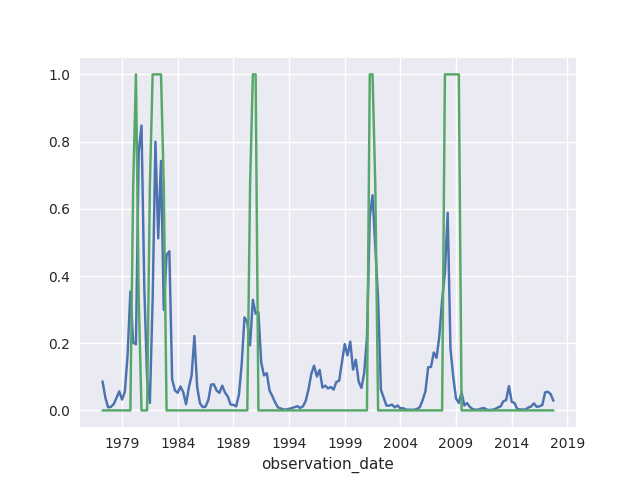

In [4]:
fig,ax = plt.subplots(1,1)
logit_model_pred.plot(ax=ax);
rec_dummy.plot(ax=ax);
plt.show()